### Imports

In [3]:
from dataclasses import dataclass
import datetime as dt
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
import sklearn
from tqdm import tqdm
import copy
import plotly.express as px
from collections import Counter

%matplotlib inline

In [4]:
from torch import nn
import torch

In [5]:
import torch
seed = 34
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [6]:
from joblib import Memory
location = os.path.abspath('./cachedir')
print(f'cache location: {location}')
memory = Memory(location, verbose=0)


cache location: /home/przemek/Projects/pp/eurocrops/notebooks/cachedir


In [7]:
plt.rcParams['figure.figsize'] = [15, 8]

### Load Data

In [8]:
ROOT_DATA_PATH = '/media/data/local/eurocrops/m1615987/'
H5_FILE_PATH = os.path.join(ROOT_DATA_PATH, 'HDF5s/train/AT_T33UWP_train.h5')

In [9]:
NUMBER_OF_CHANNELS = 13

In [10]:
def _load_data_from_h5_file(h5_file_path):
    hdf = pd.HDFStore(h5_file_path, mode='r') #here we directly load the .h5 file in one go using pandas.
    region_names = hdf.keys()  #list all the keys or regions in the region (for eg- AT112)
    region_names = region_names #[:3] - potentially limit amount of data
    df_datas = []

    for region_name in tqdm(region_names):
        df_data_single = hdf.get(f'/{region_name}') #selecting a region from based on the key (AT112 for eg.)
        df_datas.append(df_data_single)
    
    #len(set.union(*[set(x.columns) for x in df_datas]))  120 columns now, but for one region there are only 80, intesection 44
    #len(set.intersection(*[set(x.columns) for x in df_datas]))  # 120 columns now, but for one region there are only 80
    
    return df_datas, region_names
        

def _is_column_in_row_inalid(rc):
    # all_zeros = not np.any(rc) - old version - all values 0
    # new version - 2 interesting values 0 (it happens sometimes that only one channel is not zero)
    return rc[4-1] == 0 and rc[8-1] == 0  
    
    
def _find_closest_non_zero_column(time_index, common_days, dates_list, row):
    # this time step is zero, we needto find another one that is not zero.
    # To do it, find all closest non-zero columns (for all time steps for this row) 
        
    time_distance_to_nonzero_columns = [abs(common_days[time_index] - v) for v in dates_list]
    for k in range(len(time_distance_to_nonzero_columns)):
        #if not np.any(row.iloc[k]):
        if _is_column_in_row_inalid(row.iloc[k]):
            time_distance_to_nonzero_columns[k] = 9999
    closest_nonzero_column = np.argmin(time_distance_to_nonzero_columns)
    return closest_nonzero_column

    
def _resample_and_concatenate_regions_data(df_datas, resampled_days_interval):
    # Conatenation of data with different dates - fixed interval span, with finding closes date (better to use interpolation, but not with nois cloud data)
    DI = resampled_days_interval  # days interval
    common_days = list(range(DI, 365, DI))
    print(f'len(common_days) = {len(common_days)}')
    # common_days_datetime = [for day in common_days]

    # year = int(timesteps[10][:4])
    # new_year_day = dt.datetime(year=year, month=1, day=1)
    # dates_list = [((dt.datetime.strptime(date, tf)- new_year_day).days + 1) for date in timesteps]

    df_data_all = pd.DataFrame(columns=common_days)


    for df_data_single in tqdm(df_datas):
        timesteps = list(df_data_single.columns)
        year = int(timesteps[10][:4])
        new_year_day = dt.datetime(year=year, month=1, day=1)
        tf = '%Y%m%d'
        dates_list = [((dt.datetime.strptime(date, tf)- new_year_day).days + 1) for date in timesteps]
        df_data_single = df_data_single.rename(columns={old: new for old, new in zip(timesteps, dates_list)})

        closest_columns = []
        for common_day in common_days:
            closest_column = np.argmin([abs(common_day - v) for v in dates_list])
            closest_columns.append(closest_column)

        new_frames = []
        for index, row in df_data_single.iterrows():
            resampled_row_data = []
            
            for i, closest_column in enumerate(closest_columns):
                rc = row.iloc[closest_column]
                invalid_rc = _is_column_in_row_inalid(rc)
                if invalid_rc:
                    closest_nonzero_column = _find_closest_non_zero_column(
                        time_index=i,
                        common_days=common_days,
                        dates_list=dates_list, 
                        row=row)
                    rc = row.iloc[closest_nonzero_column]
                
                resampled_row_data.append(rc)

            resampled_row_df = pd.DataFrame([resampled_row_data], columns=common_days, index=[index])
            new_frames.append(resampled_row_df)

        new_frames_df = pd.concat(new_frames)
        df_data_all = pd.concat([df_data_all, new_frames_df])
    
    return df_data_all, common_days


def _load_all_labels(region_names):
    df_labels_all_lists = []
    for region_name in region_names:
        region_name = region_name.strip('/')
        LABELS_CSV_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'csv_labels/train/demo_eurocrops_{region_name}.csv')
        GEO_JSON_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'GeoJSONs_regional_split/train/AT/demo_eurocrops_{region_name}.geojson')

        # csv_file_path = os.path.join(train_csv_dir, csv_file_name)
        df_labels = pd.read_csv(LABELS_CSV_FILE_PATH, index_col=0)
        df_labels_all_lists.append(df_labels)


    df_labels_all = pd.concat(df_labels_all_lists)
    return df_labels_all
    

@memory.cache
def load_all_data_from_file_resampled(
        h5_file_path: str, 
        resampled_days_interval: int,
        ):
    df_datas, region_names = _load_data_from_h5_file(h5_file_path=h5_file_path)
    df_data_all, common_days = _resample_and_concatenate_regions_data(df_datas=df_datas, resampled_days_interval=resampled_days_interval)
    
    df_labels_all = _load_all_labels(region_names=region_names)

    return df_data_all, df_labels_all, common_days, region_names

In [11]:
df_data_all, df_labels_all, common_days, region_names = load_all_data_from_file_resampled(
    h5_file_path=H5_FILE_PATH, 
    resampled_days_interval=7,
    )

In [12]:
df_data_all.head(3)

,7,14,21,28,35,42,49,56,63,70,...,301,308,315,322,329,336,343,350,357,364
463,"[3871, 3600, 2992, 3105, 3205, 3320, 3321, 348...","[1679, 1241, 845, 742, 805, 866, 945, 854, 399...","[6992, 6542, 5944, 6414, 6786, 6859, 6973, 674...","[1456, 1079, 767, 673, 737, 796, 851, 772, 472...","[1456, 1079, 767, 673, 737, 796, 851, 772, 472...","[1511, 1079, 694, 540, 541, 580, 586, 538, 302...","[1556, 1172, 916, 862, 934, 1056, 1137, 1059, ...","[1968, 1501, 1274, 1269, 1304, 1461, 1601, 142...","[3378, 3184, 2888, 2967, 3079, 3241, 3332, 332...","[1433, 1104, 870, 855, 967, 1139, 1245, 1185, ...",...,"[1598, 1252, 998, 944, 1000, 1137, 1244, 1190,...","[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[3450, 3114, 2883, 3245, 3432, 3793, 4090, 364...","[3450, 3114, 2883, 3245, 3432, 3793, 4090, 364...","[1695, 1244, 889, 708, 763, 913, 966, 912, 343...","[1552, 1127, 692, 473, 442, 437, 421, 370, 159...","[1770, 1294, 898, 732, 802, 954, 1015, 953, 36...","[1770, 1294, 898, 732, 802, 954, 1015, 953, 36...","[1608, 1196, 756, 582, 571, 603, 590, 563, 320..."
464,"[2240, 1800, 1329, 1211, 1252, 1340, 1384, 135...","[1706, 1276, 891, 803, 863, 932, 1026, 965, 40...","[6337, 5914, 5299, 5647, 5919, 6005, 6108, 598...","[1463, 1113, 804, 734, 781, 838, 889, 868, 472...","[1463, 1113, 804, 734, 781, 838, 889, 868, 472...","[1680, 1296, 974, 977, 1058, 1167, 1265, 1248,...","[1571, 1212, 959, 933, 1005, 1100, 1177, 1165,...","[2246, 2119, 1796, 1776, 1816, 1945, 2033, 208...","[3276, 3045, 2767, 2836, 2950, 3119, 3227, 320...","[1446, 1159, 929, 942, 1020, 1157, 1283, 1271,...",...,"[1633, 1291, 1049, 994, 1063, 1229, 1321, 1281...","[1468, 1113, 788, 656, 680, 750, 802, 734, 275...","[1468, 1113, 788, 656, 680, 750, 802, 734, 275...","[2254, 1874, 1508, 1444, 1453, 1598, 1710, 158...","[2254, 1874, 1508, 1444, 1453, 1598, 1710, 158...","[1713, 1259, 903, 712, 787, 940, 975, 923, 391...","[1586, 1158, 724, 501, 475, 480, 470, 414, 177...","[1780, 1300, 907, 725, 815, 999, 1054, 996, 40...","[1780, 1300, 907, 725, 815, 999, 1054, 996, 40...","[1514, 1095, 667, 475, 471, 491, 483, 453, 232..."
504,"[5910, 5689, 5128, 5710, 5977, 6113, 6230, 607...","[1912, 1540, 1220, 1198, 1415, 1731, 1954, 198...","[5602, 5067, 4545, 4936, 5200, 5297, 5378, 505...","[1495, 1196, 949, 1011, 1179, 1441, 1588, 1637...","[1495, 1196, 949, 1011, 1179, 1441, 1588, 1637...","[1691, 1374, 1150, 1330, 1597, 1885, 2085, 220...","[1556, 1267, 1067, 1146, 1356, 1602, 1746, 180...","[2995, 2461, 2233, 2351, 2496, 2662, 2834, 267...","[3381, 3151, 2864, 2948, 3089, 3273, 3373, 334...","[1517, 1338, 1211, 1446, 1689, 2038, 2300, 239...",...,"[1480, 1140, 1014, 693, 1105, 2526, 2917, 2817...","[1557, 1225, 1029, 830, 1126, 1583, 1722, 1676...","[1557, 1225, 1029, 830, 1126, 1583, 1722, 1676...","[1607, 1266, 1029, 913, 1117, 1439, 1650, 1631...","[1607, 1266, 1029, 913, 1117, 1439, 1650, 1631...","[1697, 1279, 940, 808, 889, 948, 1058, 954, 44...","[2417, 2532, 2105, 2094, 2171, 2386, 2507, 278...","[1684, 1222, 777, 577, 566, 576, 582, 526, 259...","[1684, 1222, 777, 577, 566, 576, 582, 526, 259...","[3982, 3901, 3152, 3252, 3343, 3377, 3467, 362..."


In [13]:
df_data_all.memory_usage(deep=True).sum()

3744779280

#### Check out the data for one parcel

In [14]:
# # Pick the first row
# example_row = df_data_all.iloc[0]
# parcel_ID = example_row.name

# # Get the corresponding label
# label_code = df_labels_all.loc[parcel_ID]['crpgrpc']
# label_name = df_labels_all.loc[parcel_ID]['crpgrpn']

# print('{} grows on parcel {}'.format(label_name, parcel_ID))

In [15]:
# example_row_np = example_row.to_numpy()
# example_row_np = np.stack(example_row_np, axis=0)

# plt.rcParams['figure.figsize'] = [15, 8]
# plt.plot(common_days, example_row_np)
# # plt.legend(bands)
# plt.style.use('_classic_test_patch')
# plt.xlabel('day of year')
# plt.ylabel('channel value')
# plt.title(f'Data for parcel id {parcel_ID}')
# plt.grid()

#### Load geojson

In [16]:
def load_geometry_dict_by_parcelid_all(region_names):
    geometry_dict_by_parcelid_all = {}
    for region_name in tqdm(region_names):
        region_name = region_name.strip('/')
        GEO_JSON_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'GeoJSONs_regional_split/train/AT/demo_eurocrops_{region_name}.geojson')    

        with open(GEO_JSON_FILE_PATH, 'r') as file:
            geojson_data = json.load(file)

        geometry_dict_by_parcelid = {feature['properties']['recno']: feature['geometry'] 
                                     for feature in geojson_data['features']}
        geometry_dict_by_parcelid_all.update(geometry_dict_by_parcelid)
    return geometry_dict_by_parcelid_all


geometry_dict_by_parcelid_all = load_geometry_dict_by_parcelid_all(region_names=region_names)


100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


#### Check crop types in the current dataset

In [17]:
def get_crop_types_counts_and_ids(df_data_all, df_labels_all):
    crop_types_counts = {}
    crop_types_ids = {}

    regions_id_set = set(df_data_all.index)
    
    for i, region_id in enumerate(df_labels_all.index):
        if region_id not in regions_id_set:
            continue

        crop_name = df_labels_all.iloc[i]['crpgrpn']
        current_count = crop_types_counts.get(crop_name, 0) 
        crop_types_counts[crop_name] = current_count + 1

        if crop_name not in crop_types_ids:
            crop_types_ids[crop_name] = []
        crop_types_ids[crop_name].append(region_id)
    
    return crop_types_counts, crop_types_ids


        
crop_types_counts, crop_types_ids = get_crop_types_counts_and_ids(df_data_all=df_data_all, df_labels_all=df_labels_all)

print(f'Total crop fields: {sum(crop_types_counts.values())}')
crop_types_counts = {k: v for k, v in sorted(crop_types_counts.items(), key=lambda item: -item[1])}
crop_types_counts

Total crop fields: 345970


{'pasture_meadow': 114774,
 'others': 38532,
 'vineyards': 36165,
 'winter_common_wheat_and_spelt': 32455,
 'other_plants_harvested_green': 21260,
 'grain_maize': 19785,
 'winter_triticale': 10353,
 'winter_rye': 9449,
 'winter_barley': 8863,
 'summer_barley': 8856,
 'potatoes': 5837,
 'summer_oats': 4866,
 'winter_rape': 4032,
 'leguminous_plants': 3863,
 'other_cereals_for_the_production_of_grain': 3757,
 'sugar_beet': 3164,
 'cucurbits': 3023,
 'sunflower_and_yellow_bloomer': 3001,
 'soya': 2384,
 'fruit_of_temperate_climate_zones': 1870,
 'millet': 1330,
 'aromatic_plants_medicinal_and_culinary_plants': 1224,
 'other_industrial_crops_not_mentioned_elsewhere': 1207,
 'fresh_vegetables_melons_and_strawberries': 1070,
 'not_known': 1070,
 'winter_durum_wheat': 525,
 'summer_durum_wheat': 435,
 'summer_common_wheat_and_spelt': 434,
 'hemp': 281,
 'other_dry_pulses': 266,
 'greenhouse_under foil': 260,
 'other_oil_seed_crops': 247,
 'fallow_land_not_crop': 237,
 'arable_land_seed_and_se

In [18]:
len(df_labels_all), len(df_data_all), len(geometry_dict_by_parcelid_all)

(345970, 345970, 352037)

In [19]:
def get_data_for_crop_type(crop_name):
    data = np.zeros(shape=(len(crop_types_ids[crop_name]), len(common_days), NUMBER_OF_CHANNELS), dtype=float)
    for i, region_id in enumerate(crop_types_ids[crop_name]):
        region_data = df_data_all.loc[region_id].to_numpy()
        data[i, ...] = np.stack(region_data)
    return data


In [20]:
# @dataclass
# class CropNdviData:
#     mean: np.ndarray
#     std: np.ndarray

        
def calc_ndvi(B4, B8):
    return (B8 - B4) / (B8 + B4)
        
    
# def get_ndvi_data(data_crop) -> CropNdviData:
#     """
#     data_crop: [fields (for the crop), time (common_days), channels (bands B0-B12)]')
#     return: mean and std for ndvi "channel"
#     """
    
#     # B8-B4 / (B8+B4)   ( counting from B1 to B13)
#     B4 = data_crop[:, :, 4-1]
#     B8 = data_crop[:, :, 8-1]

#     data_crop_ndvi = calc_ndvi(B4, B8)
#     data_crop_mean_ndvi = np.mean(data_crop_ndvi, axis=0)
#     data_crop_std_ndvi = np.std(data_crop_ndvi, axis=0) 
    
#     return CropNdviData(mean=data_crop_mean_ndvi, std=data_crop_std_ndvi)
    

#### Flatten the data and labels

In [21]:
data_flatten_list = []  
data_flatten_ndvi_list = []


for index, row in df_data_all.iterrows():
    region_data = row.to_numpy()
    region_data_stacked = np.stack(region_data)
    region_data_stacked_flat = region_data_stacked.flatten('F')  # so the first channel through time is continous
    data_flatten_list.append(region_data_stacked_flat)

    B4 = region_data_stacked[:, 4-1]
    B8 = region_data_stacked[:, 8-1]
    region_data_ndvi = calc_ndvi(B4, B8)
    data_flatten_ndvi_list.append(region_data_ndvi)
    
data_flatten = np.stack(data_flatten_list)
data_ndvi_flatten = np.stack(data_flatten_ndvi_list)

In [22]:
data_flatten.shape, data_ndvi_flatten.shape

((345970, 676), (345970, 52))

In [23]:
df_labels_all

,crpgrpc,crpgrpn
recno,,
463,33111022,leguminous_plants
464,33111022,leguminous_plants
504,33111022,leguminous_plants
577,33111022,leguminous_plants
578,33111022,leguminous_plants
...,...,...
363647,33200000,pasture_meadow
363648,33200000,pasture_meadow
363676,33200000,pasture_meadow


In [24]:
all_crop_types = set(df_labels_all.iloc[:, 1].to_numpy())
data_flatten_labels = df_labels_all.iloc[:, 1].to_numpy()
print(set(data_flatten_labels))

{'winter_triticale', 'hops', 'arable_land_seed_and_seedlings', 'vineyards', 'other_oil_seed_crops', 'leguminous_plants', 'summer_triticale', 'energy_crops', 'fresh_vegetables_melons_and_strawberries', 'summer_barley', 'other_industrial_crops_not_mentioned_elsewhere', 'cucurbits', 'sunflower_and_yellow_bloomer', 'greenhouse_under foil', 'other_plants_harvested_green', 'sugar_beet', 'grain_maize', 'summer_oats', 'potatoes', 'winter_rape', 'temporary_grass', 'fruit_of_temperate_climate_zones', 'winter_rye', 'aromatic_plants_medicinal_and_culinary_plants', 'winter_durum_wheat', 'summer_durum_wheat', 'nurseries', 'other_cereals_for_the_production_of_grain', 'fodder_roots_and_brassicas', 'winter_oats', 'not_known', 'pasture_meadow', 'berry_species', 'nuts', 'summer_common_wheat_and_spelt', 'hemp', 'fallow_land_not_crop', 'winter_barley', 'flowers_and_ornamental_plants', 'winter_common_wheat_and_spelt', 'others', 'other_dry_pulses', 'millet', 'soya'}


### Select data for processing

#### choose crop types

In [25]:

# crops_to_use__names = [
#     #'pasture_meadow',
#     'grain_maize',
#     #'winter_common_wheat_and_spelt',
#     #'other_plants_harvested_green',
#     'winter_barley',
#     'vineyards',
#     'soya',
#     'sugar_beet',
#     'winter_triticale',
#     'winter_rye',
#     'leguminous_plants',
#     'sunflower_and_yellow_bloomer',
#     #'other_cereals_for_the_production_of_grain',
#     'millet',
#     'winter_rape',
#     #'fresh_vegetables_melons_and_strawberries',
#     'summer_barley',
#     #'fruit_of_temperate_climate_zones',
#     'potatoes',
#     'summer_oats',
#     'cucurbits',
#     #'other_dry_pulses',
#     'summer_durum_wheat',
#     #'arable_land_seed_and_seedlings',
#     'winter_durum_wheat',
#     #'aromatic_plants_medicinal_and_culinary_plants',
#     #'energy_crops',
#     #'summer_common_wheat_and_spelt',
#     #'temporary_grass',
#     #'other_oil_seed_crops',
#     'hemp',
#     'nuts',
#     #'flowers_and_ornamental_plants',
#     #'berry_species',
#     #'nurseries',
# ]
crops_to_use__names = [ 
#     'sunflower_and_yellow_bloomer',
#     #'nuts',
#     'soya',
#     'vineyards',
#     'potatoes',
#     'summer_barley',
    
#     'cucurbits',
#     'sugar_beet',
#     'millet',
#     'grain_maize',
    
    'vineyards',
    'sunflower_and_yellow_bloomer',
    #'nuts',
    'sugar_beet',
    'nuts',
    'hemp',
    'summer_durum_wheat',
    'hops',
    
    
]

assert(len(crops_to_use__names) == len(set(crops_to_use__names)))

In [26]:
indexes_to_use = []
for i in range(len(df_labels_all)):
    label = data_flatten_labels[i]
    if label not in crops_to_use__names:
        continue  # skip this data, not interested
    indexes_to_use.append(i)
# indexes_to_use = np.array(indexes_to_use)

selected_data_flatten_labels = np.take(data_flatten_labels, indexes_to_use)
selected_data_flatten = data_flatten[indexes_to_use, :]
selected_data_ndvi_flatten = data_ndvi_flatten[indexes_to_use, :]
len(set(selected_data_flatten_labels))

7

In [27]:
selected_data_flatten_labels.shape, selected_data_flatten.shape, selected_data_ndvi_flatten.shape

((43203,), (43203, 676), (43203, 52))

In [28]:
selected_data_flatten_labels

array(['nuts', 'nuts', 'nuts', ..., 'sugar_beet', 'sugar_beet',
       'sugar_beet'], dtype=object)

In [29]:
data_ndvi_flatten[[1,2,3,], :].shape

(3, 52)

#### Remap output classes to consecutive values


In [30]:

selected_data_flatten_labels_mapping = {value: i for i, value in enumerate(crops_to_use__names)}

selected_data_flatten_labels_mapped = np.full(shape=selected_data_flatten_labels.shape, fill_value=1, dtype=int)
for i in range(len(selected_data_flatten_labels_mapped)):
    selected_data_flatten_labels_mapped[i] = selected_data_flatten_labels_mapping[selected_data_flatten_labels[i]]

In [31]:
selected_data_flatten_labels_mapping

{'vineyards': 0,
 'sunflower_and_yellow_bloomer': 1,
 'sugar_beet': 2,
 'nuts': 3,
 'hemp': 4,
 'summer_durum_wheat': 5,
 'hops': 6}

In [32]:
len(set(selected_data_flatten_labels_mapped))

7

#### Determine the data type to use (for further processing)
And split dataset

In [33]:
x = selected_data_ndvi_flatten

y = selected_data_flatten_labels_mapped
# print(len(x))
NUMBER_OF_CLASSES = len(set(y))


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

n1, n2 = int(len(y) * 0.8), int(len(y) * 0.9)
x_shuffled, y_shuffled = unison_shuffled_copies(x, y)
x_train, x_valid, x_test = x_shuffled[:n1], x_shuffled[n1:n2], x_shuffled[n2:]
y_train, y_valid, y_test = y_shuffled[:n1], y_shuffled[n1:n2], y_shuffled[n2:]


len(x_train), len(x_valid), len(x_test)

(34562, 4320, 4321)

In [57]:
# classes distribution

_, counts = np.unique(y_test, return_counts=True)
random_guess_accuraccy = max(counts) / sum(counts)

print(f'{random_guess_accuraccy = :.3f}')
counts

random_guess_accuraccy = 0.837


array([3618,  312,  302,   21,   28,   38,    2])

## Data processing

### t-SNE

In [34]:
PLOT_TSNE_NDVI = False


if PLOT_TSNE_NDVI:
    import seaborn as sns
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(x)

    df = pd.DataFrame()
    df["y"] = selected_data_flatten_labels
    df["comp-1"] = z[:, 0]
    df["comp-2"] = z[:, 1]

    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", len(set(selected_data_flatten_labels))),
                    data=df).set(title="selected_data_flatten_labels crops")

In [35]:
if PLOT_TSNE_NDVI:
    import seaborn as sns
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=3, verbose=1, random_state=123)
    z = tsne.fit_transform(x)


    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(z[:, 0], z[:, 1], z[:, 2])


In [36]:
if PLOT_TSNE_NDVI:
    fig = px.scatter_3d(
        z, x=0, y=1, z=2,
        color=y, labels={'color': 'species'}
    )
    fig.update_traces(marker_size=8)
    fig.show()

### SVM

In [39]:
from sklearn import svm

clf = svm.SVC()
clf.fit(x_train, y_train)

y_predicted = clf.predict(x_test)

predicted_correctly = np.count_nonzero(y_predicted == y_test)
predicted_correctly, len(y_predicted)

(4257, 4321)

In [40]:
len(set(y_predicted))

7

svm_ndvi_kappa=0.909, accuraccy=0.985
svm_ndvi_kappa=0.909, accuraccy=0.985


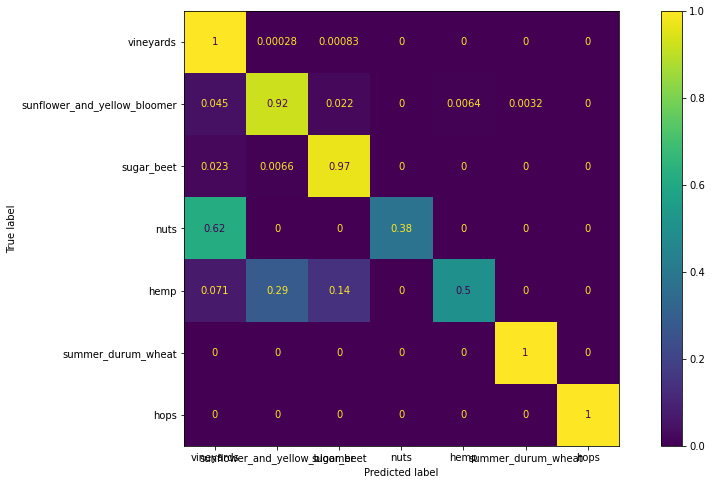

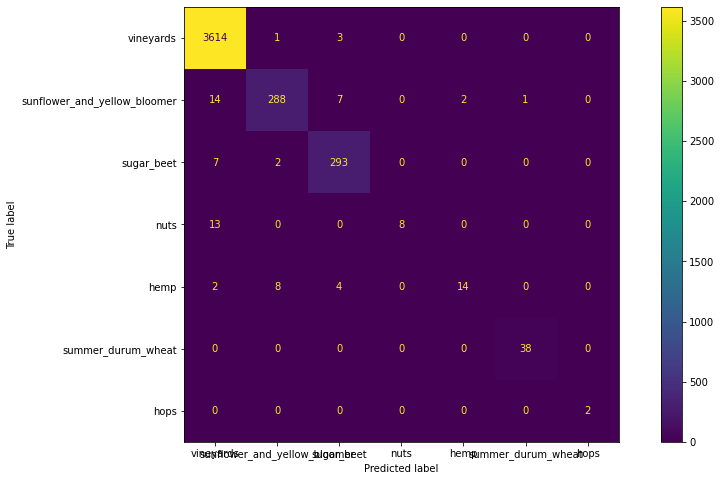

In [41]:
def draw_prediction_matrix_for_test_data(y_predicted_labels, y_test_labels, normalize='true'):
    svm_ndvi_confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_predicted_labels, 
                                                                 normalize=normalize)
    disp = sklearn.metrics.ConfusionMatrixDisplay(svm_ndvi_confusion_matrix, display_labels=crops_to_use__names)
    disp.plot()
    
    
    predicted_correctly = np.count_nonzero(y_predicted_labels == y_test_labels)

    accuraccy = predicted_correctly / len(y_test_labels)

    # https://en.wikipedia.org/wiki/Cohen%27s_kappa
    kappa = 1 - (1 - accuraccy) / (1 - random_guess_accuraccy)

    print(f'svm_ndvi_kappa={kappa:.3f}, accuraccy={accuraccy:.3f}')
    

draw_prediction_matrix_for_test_data(y_predicted, y_test)
draw_prediction_matrix_for_test_data(y_predicted, y_test, normalize=None)

### NN linear

In [42]:
NUMBER_OF_INPUTS = x[0].shape[0]
print(f'NUMBER_OF_INPUTS = {NUMBER_OF_INPUTS}, NUMBER_OF_CLASSES={NUMBER_OF_CLASSES}')


NUMBER_OF_INPUTS = 52, NUMBER_OF_CLASSES=7


In [43]:
model = nn.Sequential(
    nn.Linear(in_features=NUMBER_OF_INPUTS, out_features=200),
    nn.BatchNorm1d(num_features=200),  # batchnorm before activation
    nn.ReLU(),

    nn.Linear(in_features=200, out_features=100),
    nn.BatchNorm1d(num_features=100),
    nn.ReLU(),

    nn.Linear(in_features=100, out_features=50),
    nn.BatchNorm1d(num_features=50),
    nn.ReLU(),

    #nn.Dropout(0.1),
    nn.Linear(in_features=50, out_features=NUMBER_OF_CLASSES),
    nn.Softmax(dim=-1),  # not 0!
)

In [44]:
x_train.shape, y_train.shape

((34562, 52), (34562,))

In [45]:
x_train[0]

array([ 0.01464766,  0.07883282,  0.10950019,  0.10950019,  0.1104263 ,
        0.12547819,  0.11417889,  0.07294706,  0.13834423,  0.060693  ,
        0.13327745,  0.13327745,  0.15903549,  0.03141185,  0.18272236,
        0.17137476,  0.09794412,  0.09794412,  0.09794412,  0.22409752,
        0.22409752,  0.25460038,  0.25460038,  0.41645772,  0.63205829,
        0.68445975,  0.14804134,  0.35009823,  0.68501196,  0.69392574,
        0.67047841,  0.02818043,  0.61354962,  0.37541825,  0.44110855,
        0.26840102,  0.3220339 ,  0.20814183,  0.20814183,  0.06898907,
       -0.01383064,  0.00824253,  0.00824253,  0.12047013,  0.12047013,
        0.10974674,  0.10974674,  0.00886162,  0.00886162,  0.00886162,
        0.155521  ,  0.155521  ])

In [46]:
with torch.no_grad():
    o = model(torch.Tensor(x_train[0:2]))
o

tensor([[0.0688, 0.2547, 0.0449, 0.1257, 0.1366, 0.2587, 0.1107],
        [0.1681, 0.1591, 0.1061, 0.2009, 0.0884, 0.1172, 0.1601]])

In [47]:
np.sum(o.numpy())

1.9999999

In [48]:
class CropDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        assert len(x) == len(y)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            raise Exception("Not supported")
        return self.x[idx].astype(np.float32), self.y[idx]


batch_size = 64
trainloader = torch.utils.data.DataLoader(CropDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(CropDataset(x_valid, y_valid), batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(CropDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

next(iter(trainloader))[0].shape

torch.Size([64, 52])

In [49]:
trainloader.batch_size

64

In [50]:
def get_predicted_and_true_labels(loader):
    y_predicted_labels = []
    y_test_labels = []

    with torch.no_grad():
        model.train(False)
        for data in loader:
            inputs, labels = data
            # calculate outputs by running images through the network
            outputs = model(inputs)
            label_predicted = np.argmax(outputs.numpy(), axis=1)
            y_predicted_labels.append(label_predicted)
            y_test_labels.append(labels)


    y_test_labels = np.concatenate(y_test_labels)
    y_predicted_labels = np.concatenate(y_predicted_labels)

    predicted_correctly = np.count_nonzero(y_predicted_labels == y_test_labels)
    accuraccy = predicted_correctly / len(y_test_labels)
    print(f'{accuraccy = :.3f}')
    return y_predicted_labels, y_test_labels


In [51]:
train_loss_vec = []
valid_loss_vec = []

In [52]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)


for epoch in range(250):  
    for phase in ['train', 'valid']:
        running_loss = 0.0
        
        if phase == 'train':
            model.train(True)  # Set trainind mode = true
            dataloader = trainloader
        else:
            model.train(False)  # Set model to evaluate mode
            dataloader = validloader
        
        for i, data in enumerate(dataloader):
            inputs, labels = data

            if phase == 'train':
                optimizer.zero_grad()  # zero the parameter gradients
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            else:
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
            running_loss += loss.item()
        
        if phase == 'train':
            train_loss = running_loss / len(dataloader.dataset)
            train_loss_vec.append(train_loss)
        else:
            valid_loss = running_loss / len(dataloader.dataset)
            valid_loss_vec.append(valid_loss)

   
    print(f'[{epoch + 1}]\t train loss: {train_loss:.6f}\t valid loss: {valid_loss:.6f}')
    get_predicted_and_true_labels(validloader)
    running_loss = 0.0

print('Finished Training')

[1]	 train loss: 0.029287	 valid loss: 0.027073
accuraccy = 0.843
[2]	 train loss: 0.024505	 valid loss: 0.022905
accuraccy = 0.888
[3]	 train loss: 0.021785	 valid loss: 0.021317
accuraccy = 0.893
[4]	 train loss: 0.020876	 valid loss: 0.020744
accuraccy = 0.900
[5]	 train loss: 0.020473	 valid loss: 0.020472
accuraccy = 0.902
[6]	 train loss: 0.020237	 valid loss: 0.020187
accuraccy = 0.906
[7]	 train loss: 0.020051	 valid loss: 0.020001
accuraccy = 0.920
[8]	 train loss: 0.019886	 valid loss: 0.019816
accuraccy = 0.939
[9]	 train loss: 0.019742	 valid loss: 0.019680
accuraccy = 0.948
[10]	 train loss: 0.019591	 valid loss: 0.019540
accuraccy = 0.950
[11]	 train loss: 0.019481	 valid loss: 0.019526
accuraccy = 0.953
[12]	 train loss: 0.019368	 valid loss: 0.019443
accuraccy = 0.954
[13]	 train loss: 0.019277	 valid loss: 0.019274
accuraccy = 0.959
[14]	 train loss: 0.019211	 valid loss: 0.019231
accuraccy = 0.960
[15]	 train loss: 0.019160	 valid loss: 0.019148
accuraccy = 0.961
[16]

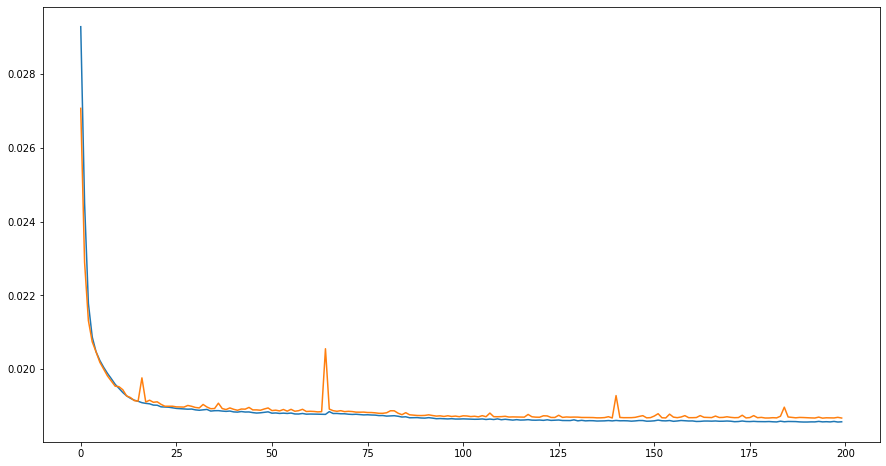

In [53]:
plt.plot(train_loss_vec)
plt.plot(valid_loss_vec)
plt.show()

accuraccy = 0.980
svm_ndvi_kappa=0.875, accuraccy=0.980
svm_ndvi_kappa=0.875, accuraccy=0.980


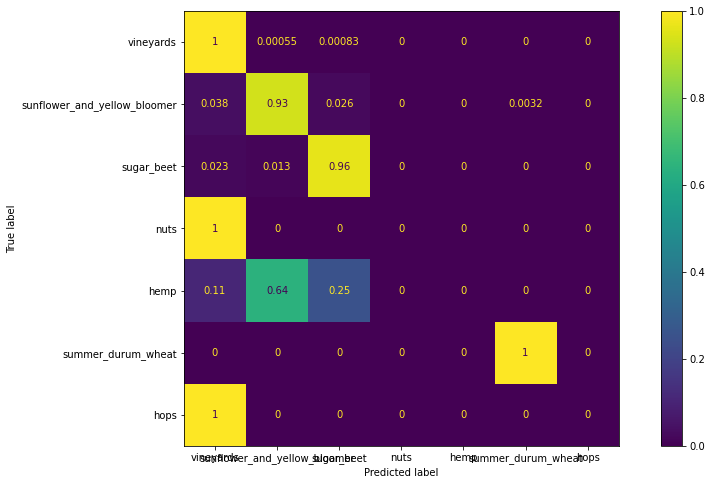

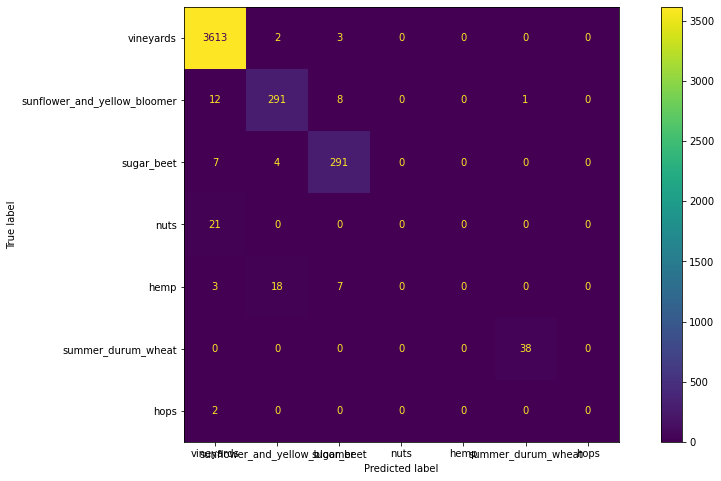

In [55]:
y_predicted_labels_test, y_test_labels = get_predicted_and_true_labels(testloader)
draw_prediction_matrix_for_test_data(y_predicted_labels_test, y_test_labels)
draw_prediction_matrix_for_test_data(y_predicted_labels_test, y_test_labels, normalize=None)